## QPEの簡単な例を実装する

では実際に、簡単な回路を使って量子位相推定を実装してみましょう。

まず、あるユニタリー演算$U$に対して$U|\psi\rangle=e^{2\pi i\theta}|\psi\rangle$となる固有ベクトル$|\psi\rangle$が必要ですが、ここでは$U$として1量子ビットの$S$ゲート（位相$\sqrt{Z}$ゲート）を考えてみます。$|1\rangle=\begin{pmatrix}0\\1\end{pmatrix}$として、$S|1\rangle=e^{i\pi/2}|1\rangle$となるので$|1\rangle$は$S$の固有ベクトル、$e^{i\pi/2}$がその固有値です。QPEは固有値$e^{2\pi i\theta}$の位相$\theta$を求めるので、$S$の場合は$\theta=1/4$を求めることに相当します。これを回路を使って実際に確かめてみます。

In [8]:
# Tested with python 3.11.13, qiskit 2.1.0
from fractions import Fraction
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

import qiskit.quantum_info as qi
from qiskit.circuit.library import UnitaryGate

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime.accounts import AccountNotFoundError
from qiskit.visualization import plot_distribution

# ワークブック独自のモジュール
import sys
#sys.path.append('/home/jovyan/qc-workbook-lecturenotes/ja')
from qc_workbook.utils import operational_backend

In [9]:
n_meas = 3

# 位相測定用のレジスタ
qreg_meas = QuantumRegister(n_meas, name='meas')
# 固有ベクトルを保持するレジスタ
qreg_aux = QuantumRegister(1, name='aux')
# 位相測定の結果が書き出される古典レジスタ
creg_meas = ClassicalRegister(n_meas, name='out')

# 2つの量子レジスタと1つの古典レジスタから量子回路を作る
circuit = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)

# それぞれのレジスタを初期化
circuit.h(qreg_meas)
circuit.x(qreg_aux)

# angle/(2π)がQPEで求めたい位相
angle = np.pi / 2

# S = P(π/2)なので、(Controlled-S)^x を CP(xπ/2) で代替
for x, ctrl in enumerate(qreg_meas):
    circuit.cp(angle * (2 ** x), ctrl, qreg_aux[0])

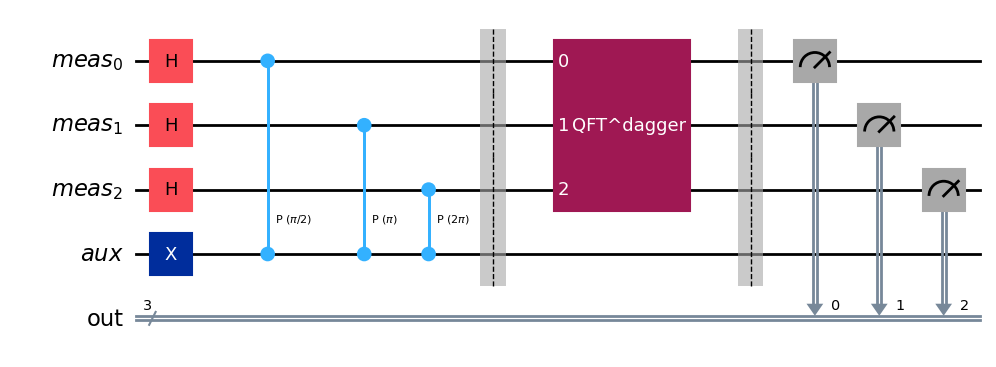

In [10]:
def qft_dagger(qreg):
    """逆量子フーリエ変換用の回路"""
    circuit = QuantumCircuit(qreg)

    ##################
    ### EDIT BELOW ###
    ##################

    #circuit?
    for j in range(qreg.size // 2):
        circuit.swap(qreg[j], qreg[-1 - j])

    for itarg in range(qreg.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1
            circuit.cp(-2. * np.pi * (2 ** power), ictrl, itarg)

        circuit.h(itarg)

    ##################
    ### EDIT ABOVE ###
    ##################

    circuit.name = "QFT^dagger"
    return circuit

circuit.barrier()
circuit.append(qft_dagger(qreg_meas), qargs=qreg_meas)
circuit.barrier()
circuit.measure(qreg_meas, creg_meas)
circuit.draw('mpl')

### シミュレータでの実験

シミュレータで実行して、測定結果の確率分布を作ってみます。

In [11]:
shots = 1000

simulator = AerSimulator()
sampler = AerSampler()

circuit = transpile(circuit, backend=simulator)
job = sampler.run([circuit], shots=shots)

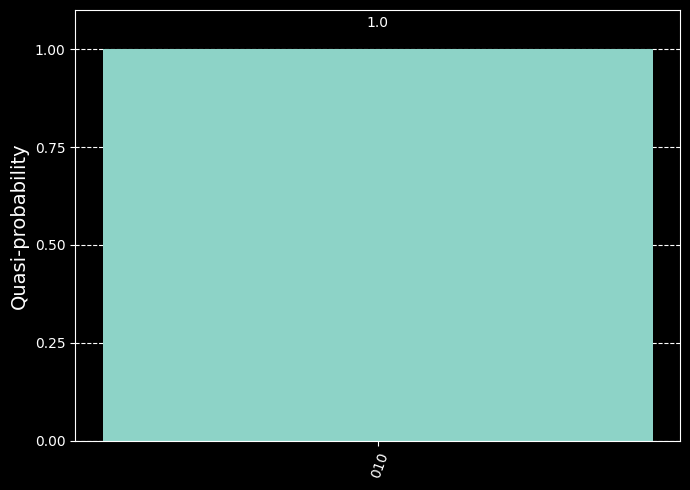

In [12]:
plt.style.use('dark_background')
plot_distribution(job.result()[0].data.out.get_counts())

ここで見た量子回路はシンプルですが、いろいろ拡張して振る舞いを理解するのに役立ちます。例えば、以下の問題を調べてみてください。
- （グローバル因子を除いて）$S=R_Z(\pi/2)$ゲートの例を見ましたが、角度を$0<\phi<\pi$の範囲で変えた$R_Z(\phi)$ゲートではどうなるでしょうか？
- 角度の選び方によっては、得られる位相の精度が悪くなります。その場合、どうすればより良い精度で測定できるでしょうか？
- $S$ゲートの場合固有ベクトルは$|1\rangle$でしたが、$|1\rangle$以外の状態を使うとどうなりますか？特に固有ベクトルと線形従属なベクトルを使った場合の振る舞いを見てみてください。

### 量子コンピュータでの実験

最後に量子コンピュータで実行して、結果を確認してみましょう、以下のようにすることで、現時点でbusyでないマシンを優先的に選んで実行してくれます。

# 量子コンピュータで実行する場合
# IBMidの登録が済んでいる場合はこちら
#instance = 'ibm-q-utokyo/internal/qc-training2023s'
instance = 'ibm-q-utokyo/internal/icepp'  # For internal use

# まだの場合はこちら
#instance = 'ibm-q/open/main'

try:
    service = QiskitRuntimeService(channel='ibm_quantum', instance=instance)
except AccountNotFoundError:
    service = QiskitRuntimeService(channel='ibm_quantum', token='__paste_your_token_here__', instance=instance)

# 最も空いているバックエンドを見つけて、そのバックエンドに対して回路をトランスパイル
backend = service.least_busy(min_num_qubits=n_meas+1, simulator=False, operational=True)
print(f"least busy backend: {backend.name}")

qc = transpile(qc, backend=backend)

In [16]:
from qiskit_ibm_runtime import Sampler, Session

# create a Runtime session for efficient execution (optional)
session = Session(service=service, backend=backend)
sampler = Sampler(session=session)

job = sampler.run(qc)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Session ID: {job.session_id}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: crd1aq2djmqg008kf2c0
>>> Session ID: crd1aptdqdn000834ta0
>>> Job Status: JobStatus.QUEUED


In [24]:
# Use a job id from a previous result
job = service.job("crd1aq2djmqg008kf2c0")
print(f">>> Job Status: {job.status()}")

>>> Job Status: JobStatus.QUEUED


In [ ]:
result = job.result()
plot_distribution(result.quasi_dists[0])

## QPEの実装2


In [13]:
# ランダムな１量子ビットユニタリーUを生成し、Uの固有値と固有ベクトルを得る
randum_unitary = qi.random_unitary(2, seed=1234)
w, vec = np.linalg.eig(randum_unitary.data)
w = w[0]
vec = vec[:, 0]

# 位相を確認
arg = np.log(w)
arg = arg.imag * 1.j
#print(arg)
theta = (arg / (2*np.pi) * (-1j)).real
assert 0 <= theta < 1
#print(theta)
print(f"real phase value: {theta}")

real phase value: 0.4582020868266377


In [14]:
# ランダムユニタリーをゲートに変換
random_unitary_gate = UnitaryGate(randum_unitary, label='U_random')
random_unitary_gate.name = 'U_random'

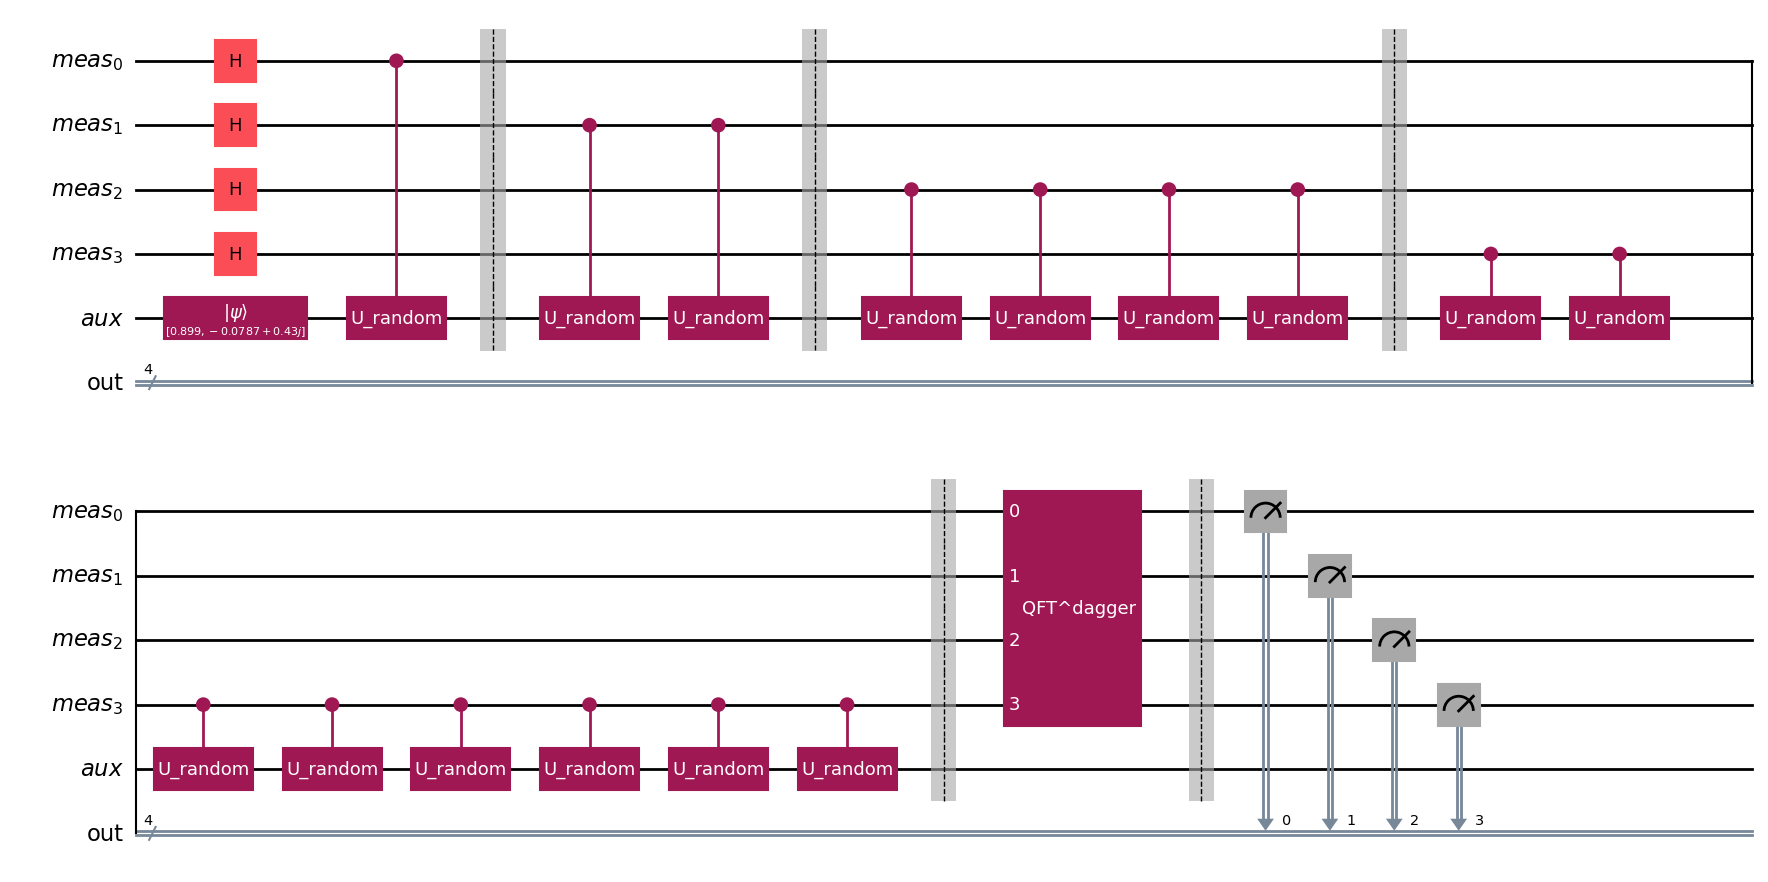

In [15]:
n_qubits = 4

# 2つの量子レジスタと1つの古典レジスタから量子回路を作る
qreg_meas = QuantumRegister(n_qubits, name='meas')
qreg_aux = QuantumRegister(1, name='aux')
creg_meas = ClassicalRegister(n_qubits, name='out')

circuit = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)

# 測定用レジスタを初期化
circuit.h(qreg_meas)

# 固有ベクトルを用意
circuit.initialize(vec, qreg_aux)

for i in range(n_qubits):
    for _ in range(2**i):
        # ユニタリゲートを制御ユニタリゲートとして回路に追加する。
        circuit.append(random_unitary_gate.control(), [i, n_qubits])
    circuit.barrier()

# 逆QFT回路を追加
circuit.append(qft_dagger(qreg_meas), qargs=qreg_meas)
circuit.barrier()
circuit.measure(qreg_meas, creg_meas)
circuit.draw('mpl')

In [16]:
shots = 1000

circuit = transpile(circuit, backend=simulator)
job = sampler.run([circuit], shots=shots)

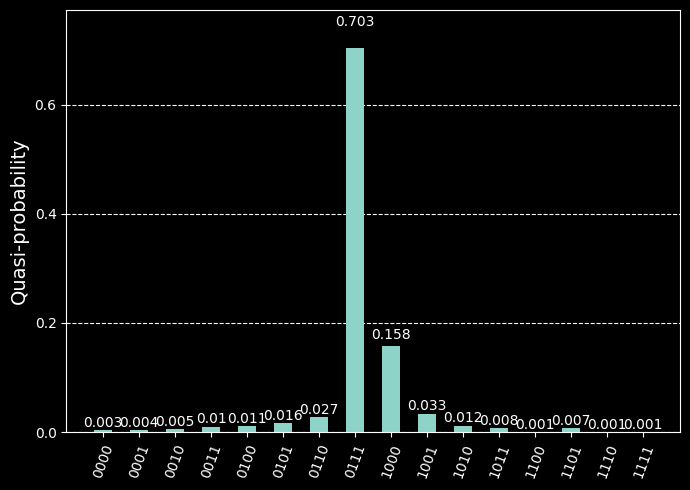

In [17]:
plt.style.use('dark_background')
counts = job.result()[0].data.out.get_counts()
plot_distribution(counts)

In [18]:
counts_items = sorted(counts.items(), key=lambda k_v: -k_v[1])
#print(counts_items)

state, count = counts_items[0]
estimated_theta = int(state, 2) / (2**n_qubits)
print(f'estimated phase = {estimated_theta}, real phase = {theta}')

estimated phase = 0.4375, real phase = 0.4582020868266377


## アルゴリズムの実装

ここから、ショアのアルゴリズムを実装していきます。

### 位数の発見

まず最初に、繰り返しの位数（周期）を発見するアルゴリズムを見てみます。

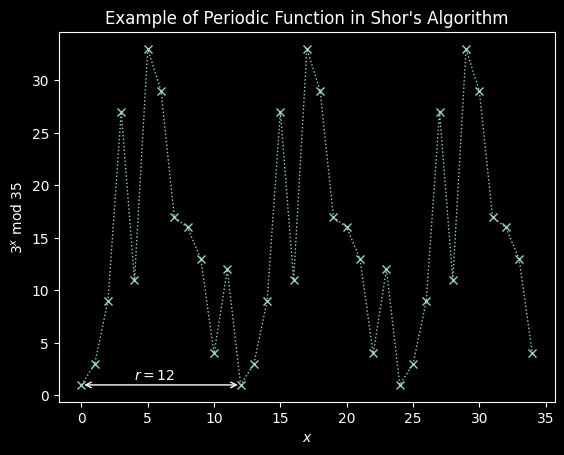

In [7]:
N = 35
a = 3

# プロットするデータを計算する
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# matplotlibを使って描画
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # グラフ上にrをプロット
    r = yvals[1:].index(1) + 1
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')

### オラクルの実装

In [8]:
def c_amod15(a, power):
    """mod 15による制御ゲート"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")

    U = QuantumCircuit(4)

    ##################
    ### EDIT BELOW ###
    ##################

    #U.?

    if a in [2, 13]:
        # 下の位を上に移すので、上の位から順にSWAPしていく
        U.swap(3, 2)
        U.swap(2, 1)
        U.swap(1, 0)
    elif a in [4, 11]:
        # 「一つ飛ばし」のビットシフト
        U.swap(3, 1)
        U.swap(2, 0)
    elif a in [8, 7]:
        # 下から順
        U.swap(1, 0)
        U.swap(2, 1)
        U.swap(3, 2)

    if a in [7, 11, 13]:
        U.x([0, 1, 2, 3])

    ##################
    ### EDIT ABOVE ###
    ##################

    # Uを2^l回繰り返す
    U_power = U.repeat(2 ** l)

    # U_powerをゲートに変換
    gate = U_power.to_gate()
    gate.name = f"{a}^{2 ** l} mod 15"

    # gateを制御ゲートに変換
    c_gate = gate.control()
    return c_gate

### 回路全体の実装

測定用ビットとして、8量子ビットを使います。

In [11]:
# 15と互いに素な数
a = 7

# 測定用ビットの数（位相推定の精度）
n_meas = 8

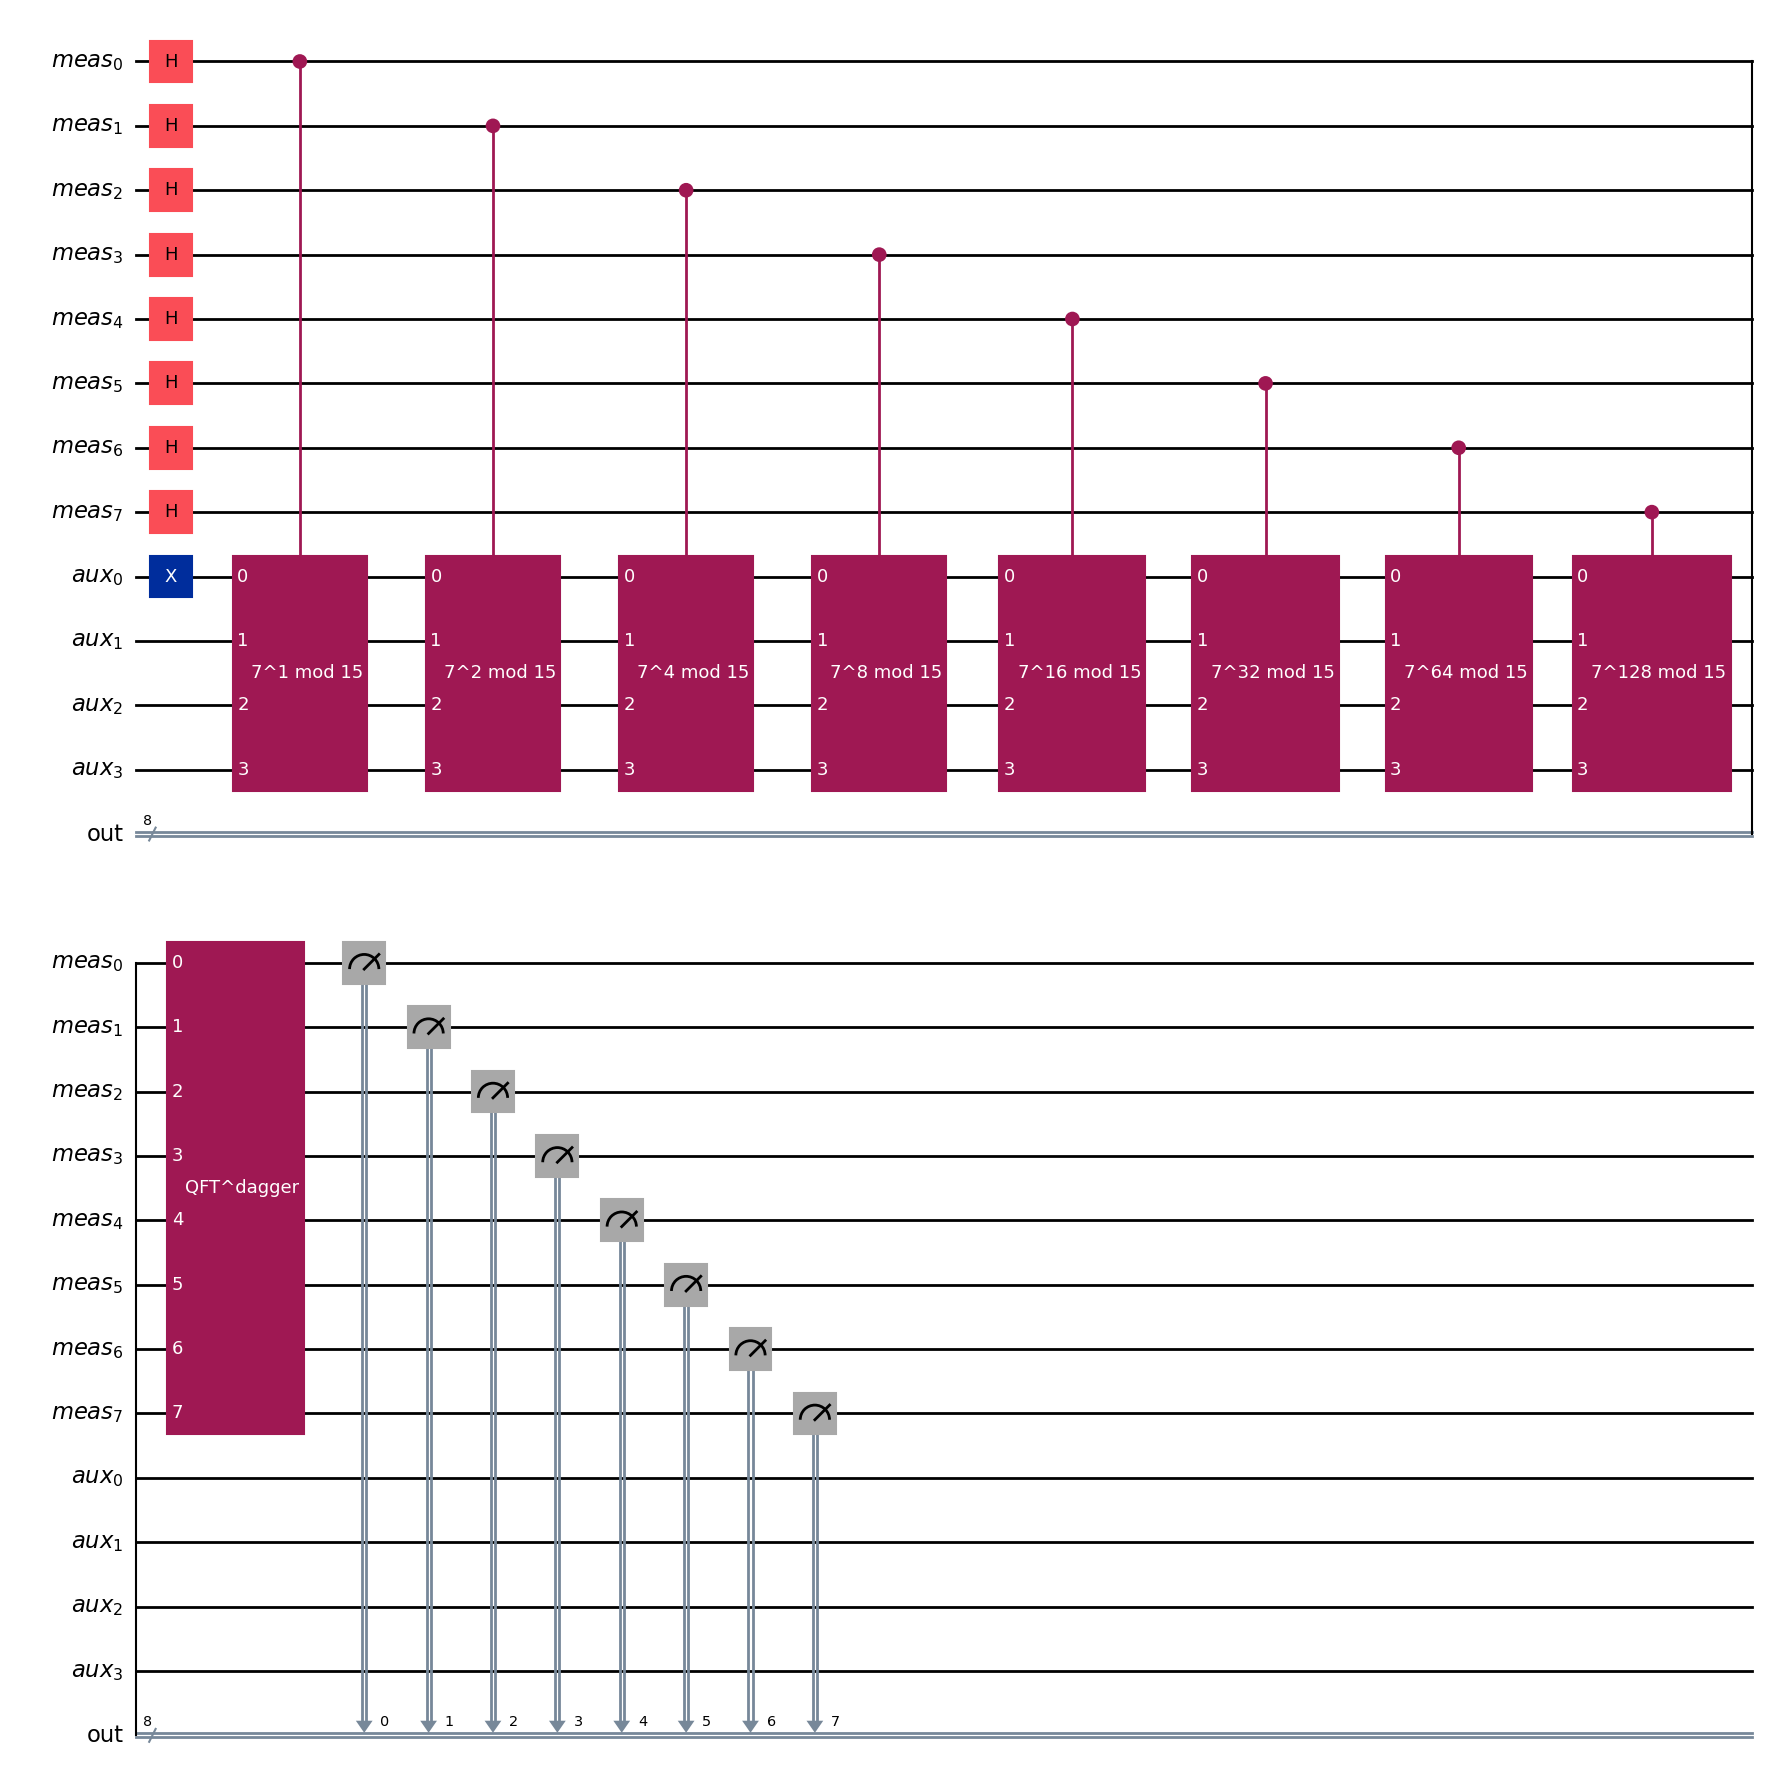

In [12]:
# 位相測定用のレジスタ
qreg_meas = QuantumRegister(n_meas, name='meas')
# Uを作用させる作業用レジスタ
qreg_aux = QuantumRegister(4, name='aux')
# 位相測定の結果が書き出される古典レジスタ
creg_meas = ClassicalRegister(n_meas, name='out')

# 2つの量子レジスタと1つの古典レジスタから量子回路を作る
circuit = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)

# 測定用レジスタをequal superpositionに初期化
circuit.h(qreg_meas)
# 作業用レジスタを|1>に初期化
circuit.x(qreg_aux[0])

# 制御Uゲートを適用
for l, ctrl in enumerate(qreg_meas):
    circuit.append(c_amod15(a, l), qargs=([ctrl] + qreg_aux[:]))

# 逆QFTを適用
circuit.append(qft_dagger(qreg_meas), qargs=qreg_meas)

# 回路を測定
circuit.measure(qreg_meas, creg_meas)
circuit.draw('mpl')

シミュレータで実行して、結果を確認してみます。

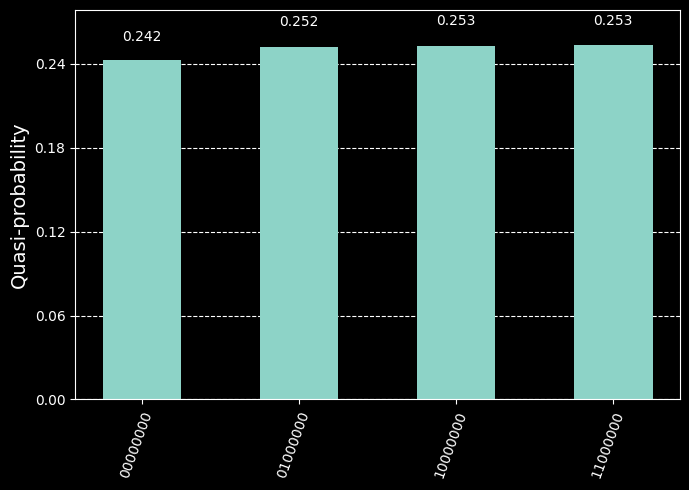

In [14]:
shots = 10000

#simulator = AerSimulator()
#sampler = AerSampler()

circuit = transpile(circuit, backend=simulator)

# Now run the job and examine the results
job = sampler.run([circuit], shots=shots)
answer = job.result()[0].data.out.get_counts()

plt.style.use('dark_background')
plot_distribution(answer)

### 計算結果の解析
出力された結果から、位相を求めてみます。

In [24]:
rows, measured_phases = [], []
for output in answer:
    out = int(output, 2)
    phase = out / (2 ** n_meas)
    measured_phases.append(phase)
    # これらの値をテーブルの行に追加：
    rows.append(f"{out:3d}      {out:3d}/{2 ** n_meas} = {phase:.3f}")

# 結果を表示
print('Register Output    Phase')
print('------------------------')

for row in rows:
    print(row)

Register Output    Phase
------------------------
  0        0/256 = 0.000
192      192/256 = 0.750
128      128/256 = 0.500
 64       64/256 = 0.250


得られた位相の情報から、連分数アルゴリズムを使用して$s$と$r$を見つけることができます。Pythonの組み込みの`fractions`(分数)モジュールを使用して、小数を`Fraction`オブジェクトに変換できます。

In [25]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append(f'{phase:10.3f}      {frac.numerator:2d}/{frac.denominator:2d} {frac.denominator:13d}')

# 結果を表示
print('     Phase   Fraction   Guess for r')
print('-------------------------------------')

for row in rows:
    print(row)

     Phase   Fraction   Guess for r
-------------------------------------
     0.000       0/ 1             1
     0.750       3/ 4             4
     0.500       1/ 2             2
     0.250       1/ 4             4


limit_denominatorメソッドを使って、分母が特定の値（ここでは15）を下回る分数で、最も位相の値に近いものを得ています。

測定された結果のうち、2つ（64と192）が正しい答えである$r=4$を与えたことが分かります。

### コードの答え

逆量子フーリエ変換

In [ ]:
    ##################
    ### EDIT BELOW ###
    ##################

    # SWAPを忘れないように!
    for j in range(qreg.size // 2):
        qc.swap(qreg[j], qreg[-1 - j])

    for itarg in range(qreg.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1
            qc.cp(-2. * np.pi * (2 ** power), ictrl, itarg)

        qc.h(itarg)

    ##################
    ### EDIT ABOVE ###
    ##################

オラクルの実装

In [ ]:
    ##################
    ### EDIT BELOW ###
    ##################

    if a in [2, 13]:
        # 下の位を上に移すので、上の位から順にSWAPしていく
        U.swap(3, 2)
        U.swap(2, 1)
        U.swap(1, 0)
    elif a in [4, 11]:
        # 「一つ飛ばし」のビットシフト
        U.swap(3, 1)
        U.swap(2, 0)
    elif a in [8, 7]:
        # 下から順
        U.swap(1, 0)
        U.swap(2, 1)
        U.swap(3, 2)

    if a in [7, 11, 13]:
        U.x([0, 1, 2, 3])

    ##################
    ### EDIT ABOVE ###
    ##################